In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate, Activation, Multiply, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img


dataset_dir="/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images"

def load_dataset(base_path):
    images = []
    masks = []

    for folder in range(1, 214):
        folder_name = f'{folder:03d}'
        folder_path = os.path.join(base_path, folder_name)

        # Skip if folder doesn't exist
        if not os.path.exists(folder_path):
            continue

        # Load images
        img_folder = os.path.join(folder_path, 'images')
        mask_folder = os.path.join(folder_path, 'masks')

        for img_file in os.listdir(img_folder):
            if img_file.endswith('.bmp'):
                # Load and preprocess image
                img_path = os.path.join(img_folder, img_file)
                mask_path = os.path.join(mask_folder, img_file.replace('.bmp', '.png'))

                image = load_img(img_path, target_size=(128, 128))  # Resize image to 128x128
                mask = load_img(mask_path, target_size=(128, 128), color_mode='grayscale')
                image = img_to_array(image) / 255.0
                mask = img_to_array(mask) / 255.0

                images.append(image)
                masks.append(mask)

    return np.array(images), np.array(masks)



    
def attention_block(x, gating, inter_channels):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = Conv2D(inter_channels, 3, strides=(shape_x[1] // shape_g[1], shape_x[2] // shape_g[2]), padding='same')(x)
    phi_g = Conv2D(inter_channels, 1, padding='same')(gating)

    concat_xg = concatenate([theta_x, phi_g], axis=3)
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, 1, padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_sigmoid = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    return Multiply()([upsample_sigmoid, x])

# Build the Attention U-Net model
def attention_unet_model(input_shape=(128, 128, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder with Attention Gates
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    att6 = attention_block(conv4, up6, inter_channels=256)
    merge6 = concatenate([att6, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    att7 = attention_block(conv3, up7, inter_channels=128)
    merge7 = concatenate([att7, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    att8 = attention_block(conv2, up8, inter_channels=64)
    merge8 = concatenate([att8, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    att9 = attention_block(conv1, up9, inter_channels=32)
    merge9 = concatenate([att9, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

# IoU metric
def iou_metric(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Dice coefficient metric
def dice_metric(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# Load and preprocess the dataset
images, masks = load_dataset(dataset_dir)
print("Initial mask shape:", masks.shape)
# Ensure masks are binary
masks = (masks > 0.5).astype(np.float32)
print("Adjusted mask shape:", masks.shape)
# Expand mask dimensions if necessary
if masks.shape[-1] != 1:
    masks = np.expand_dims(masks, axis=-1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Instantiate the model
attention_model = attention_unet_model(input_shape=(128, 128, 3), num_classes=1)
attention_model.summary()
# Compile the model
attention_model.compile(optimizer=Adam(learning_rate=1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy', Precision(name='precision_metric'), iou_metric, dice_metric])

# Train the model
history = attention_model.fit(X_train, y_train, 
                              validation_data=(X_val, y_val), 
                              epochs=50, 
                              batch_size=8,
                              verbose=1)

# Save the trained model
attention_model.save("/kaggle/working/attention_unet_iitd.h5")
    
    

Initial mask shape: (2130, 128, 128, 1)
Adjusted mask shape: (2130, 128, 128, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 512)    │      2,097,664 │ up_sampling2d[0][0]    │
├──────────────────────

 Total params: 32,774,469 (125.02 MB)

 Trainable params: 32,774,469 (125.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 90s 251ms/step - accuracy: 0.7570 - dice_metric: 0.4737 - iou_metric: 0.3288 - loss: 0.4408 - precision_metric: 0.5740 - val_accuracy: 0.9320 - val_dice_metric: 0.7872 - val_iou_metric: 0.6500 - val_loss: 0.1739 - val_precision_metric: 0.9331
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 38s 180ms/step - accuracy: 0.9350 - dice_metric: 0.8006 - iou_metric: 0.6701 - loss: 0.1826 - precision_metric: 0.8855 - val_accuracy: 0.9492 - val_dice_metric: 0.8152 - val_iou_metric: 0.6892 - val_loss: 0.1516 - val_precision_metric: 0.9078
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 39s 185ms/step - accuracy: 0.9419 - dice_metric: 0.8193 - iou_metric: 0.6964 - loss: 0.1679 - precision_metric: 0.8966 - val_accuracy: 0.9519 - val_dice_metric: 0.8369 - val_iou_metric: 0.7208 - val_loss: 0.1412 - val_precision_metric: 0.9195
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.9453 - dice_metric: 0.8312 - iou_metric: 0.7131 - loss: 0.1602 - precision_metric:

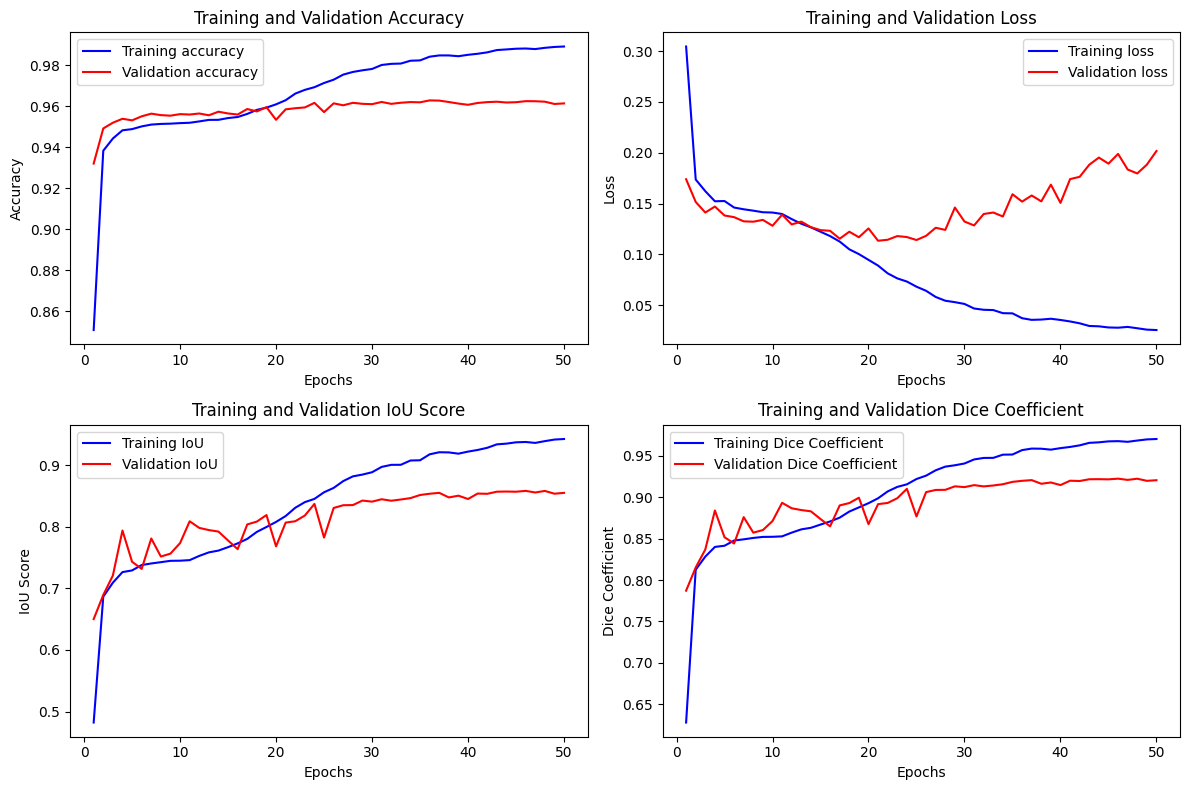

In [2]:
import matplotlib.pyplot as plt

# Retrieve the history data
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
iou = history.history['iou_metric']
val_iou = history.history['val_iou_metric']
dice = history.history['dice_metric']
val_dice = history.history['val_dice_metric']

epochs = range(1, len(accuracy) + 1)

# Plot model accuracy
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot model loss
plt.subplot(2, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot IoU score
plt.subplot(2, 2, 3)
plt.plot(epochs, iou, 'b', label='Training IoU')
plt.plot(epochs, val_iou, 'r', label='Validation IoU')
plt.title('Training and Validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()

# Plot Dice coefficient
plt.subplot(2, 2, 4)
plt.plot(epochs, dice, 'b', label='Training Dice Coefficient')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


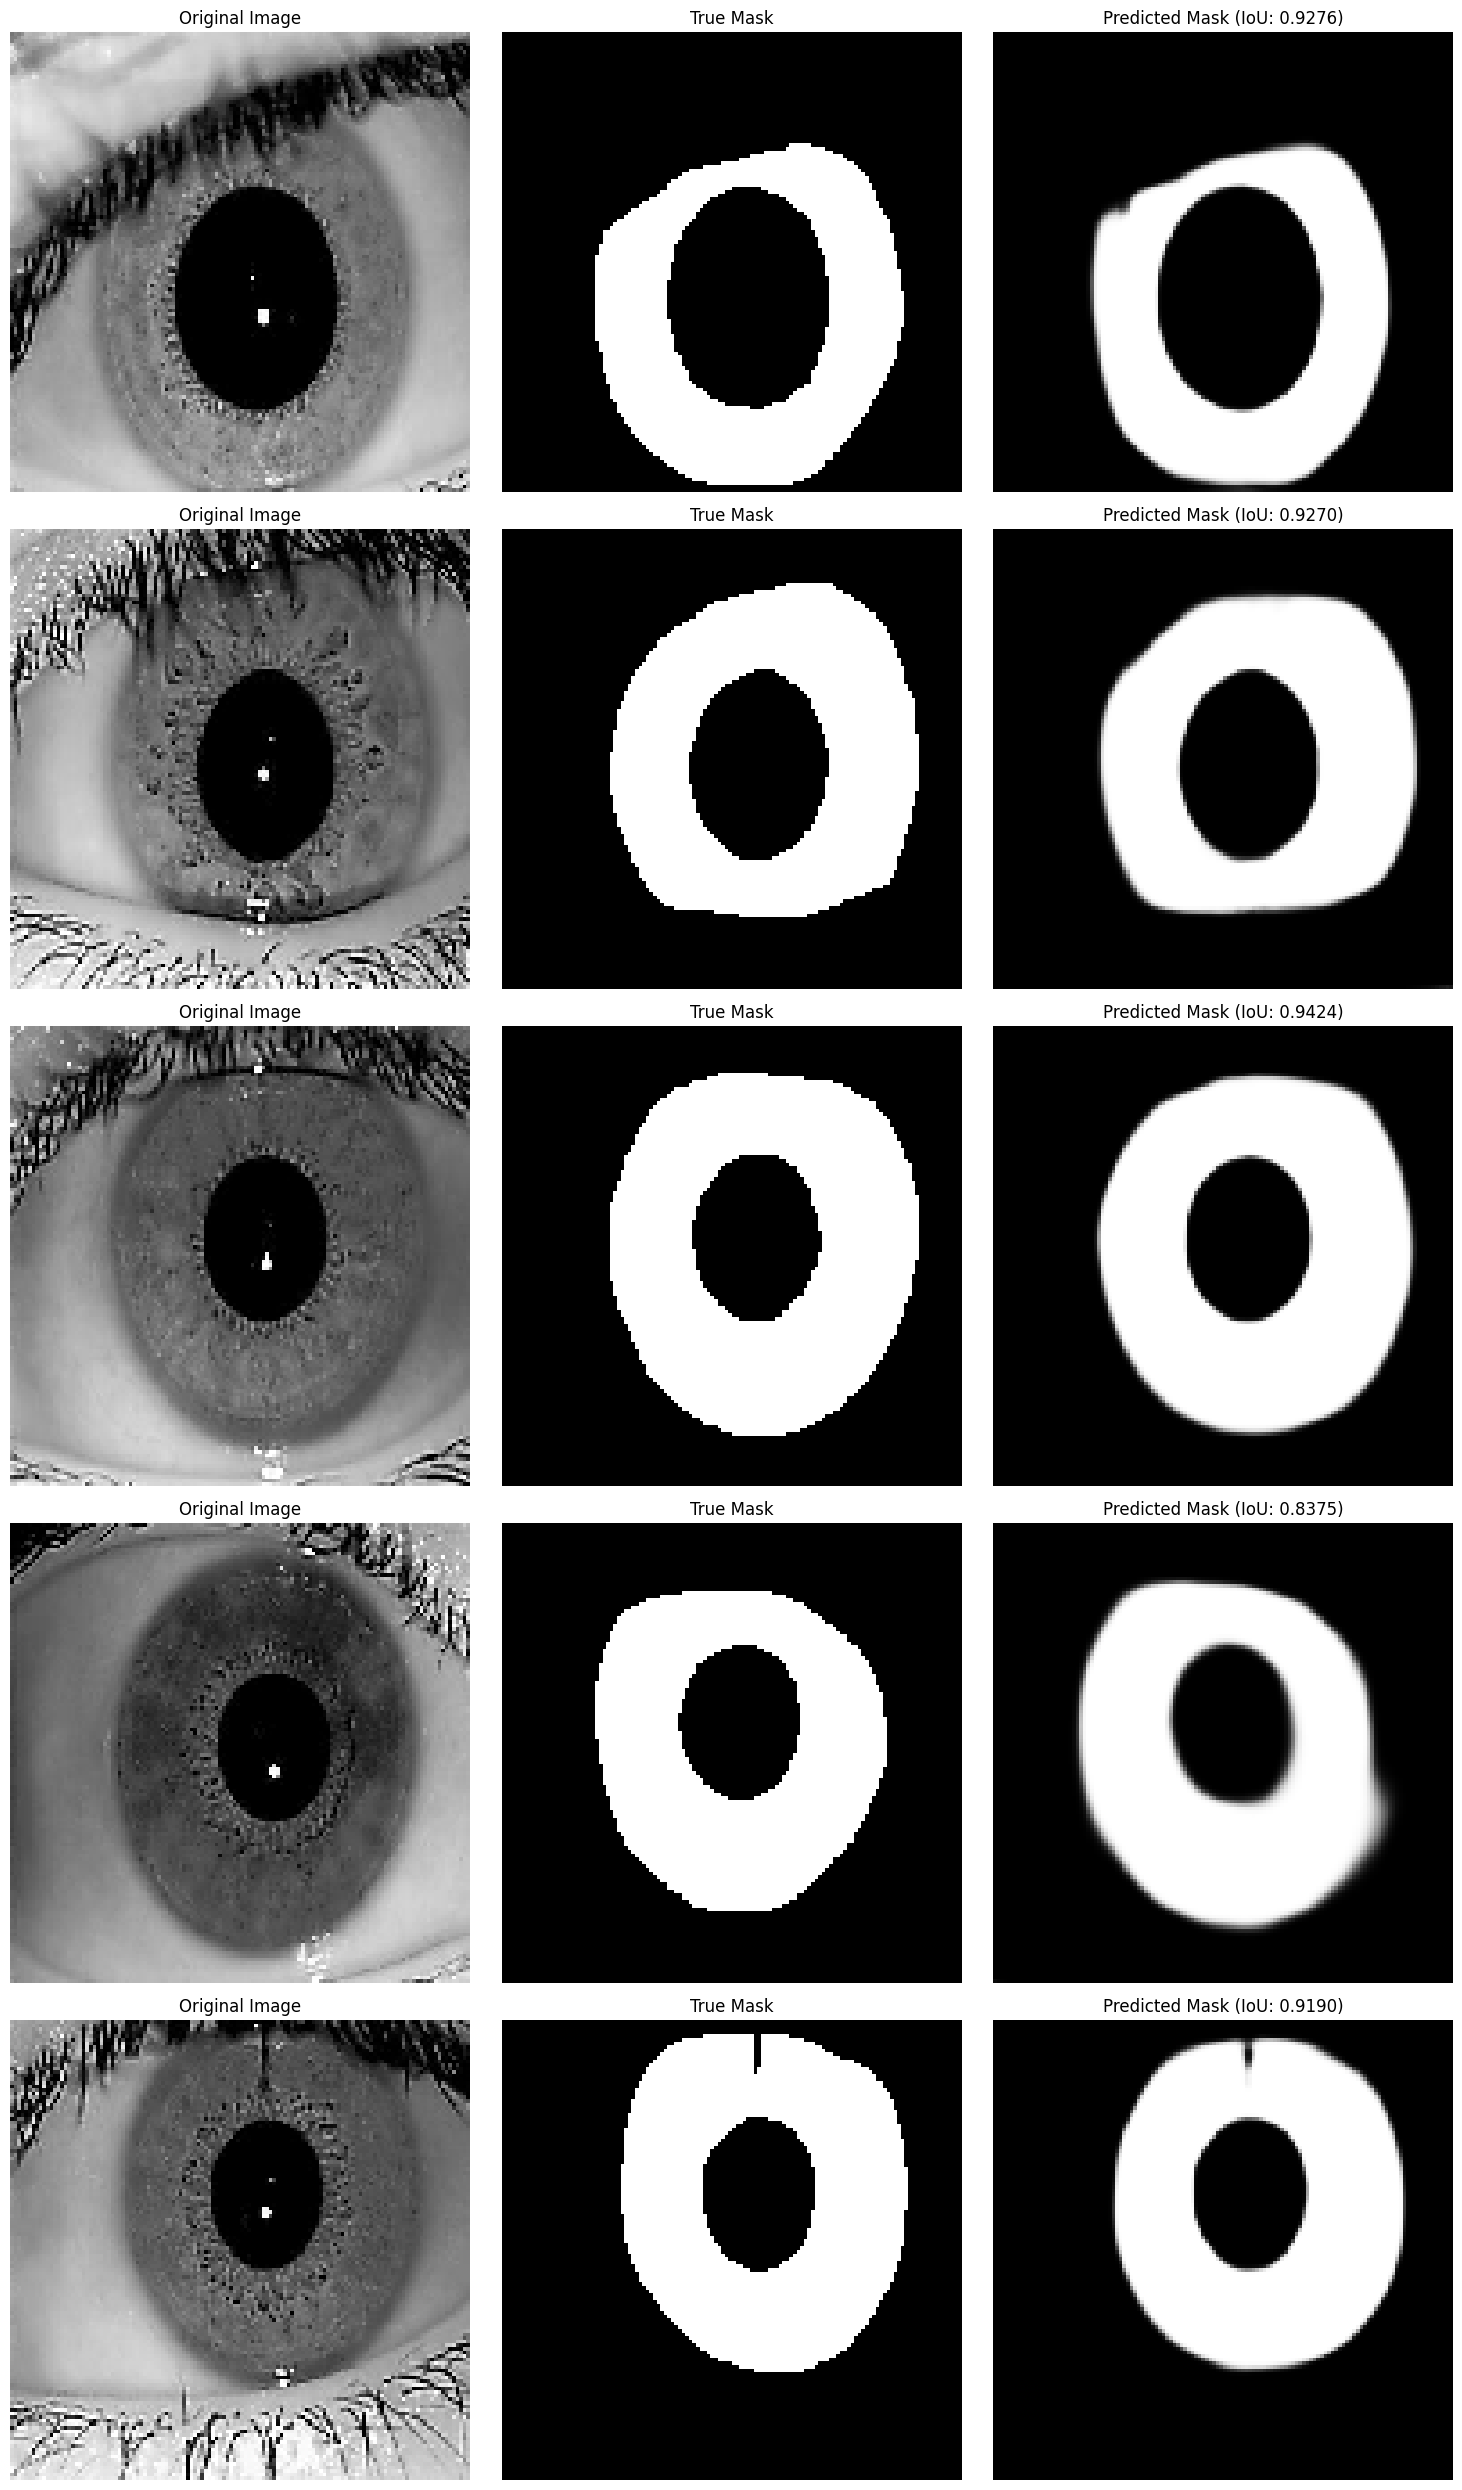

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to compute IoU for a single image
def compute_iou(y_true, y_pred):
    # Binarize the predicted mask using 0.5 threshold
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    # Intersection and Union
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    
    return intersection / (union + 1e-7)  # Small epsilon to avoid division by zero

# Function to display predictions and compute IoU
def display_predictions(attention_model, X_val, y_val, num_images=5):
    # Select random images from the validation set
    indices = np.random.choice(len(X_val), num_images, replace=False)
    
    plt.figure(figsize=(15, num_images * 5))
    
    for i, idx in enumerate(indices):
        # Original image and true mask
        original_image = X_val[idx]
        true_mask = y_val[idx]
        
        # Predict mask
        predicted_mask = attention_model.predict(np.expand_dims(original_image, axis=0))[0]
        
        # Compute IoU
        iou_score = compute_iou(true_mask, predicted_mask)
        
        # Display the original image, true mask, and predicted mask
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_image)  # Keep the original image in color
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(np.squeeze(true_mask), cmap='gray')
        plt.title(f"True Mask")
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(np.squeeze(predicted_mask), cmap='gray')
        plt.title(f"Predicted Mask (IoU: {iou_score:.4f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display 5 images with IoU scores
display_predictions(attention_model, X_val, y_val, num_images=5)

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/02_L.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/04_L.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/06_R.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/08_R.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/01_L.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/05_L.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/07_R.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/03_L.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/09_R.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/images/10_R.bmp
/kaggle/input/iitdb__/other/default/1/Annotations/Masks and Images/135/masks/07_R.png
/kaggle/input/iitdb__/other/default/1/Annota